# 📈 Daft Quant 量化交易系统演示

## KDJ 指标策略开发与回测

本 Notebook 演示如何：
1. **编写新策略** - 基于 KDJ 指标的交易策略
2. **运行回测** - 使用回测引擎验证策略效果
3. **查看结果** - 生成报告和可视化图表

---

## 1. 环境准备

### ⚠️ 重要：选择正确的 Jupyter 内核

如果运行时提示找不到模块，请按以下步骤操作：

1. **点击右上角** 的内核选择按钮（显示 Python 版本或 "选择内核"）
2. **选择** `base (Python 3.x)` 或 `C:\ProgramData\anaconda3\python.exe`
3. **重新运行** 下方的环境检查单元格

---

导入必要的库和模块。

In [1]:
# ========================================
# 环境检查 - 运行此单元格验证 Jupyter 使用正确的 Python 环境
# ========================================
import sys
print(f"Python 解释器路径: {sys.executable}")
print(f"Python 版本: {sys.version}")

# 验证 xtquant 是否可用（Mini-QMT 必需）
try:
    import xtquant
    print("✅ xtquant 已安装 - 环境正确!")
except ImportError as e:
    print("❌ xtquant 未找到 - 请在 VS Code 右上角选择正确的 Python 内核:")
    print("   点击右上角的 '选择内核' -> 选择 'Python 3 (ipykernel)' 或 'base (Python 3.x)'")
    print(f"   应使用的解释器: C:\\ProgramData\\anaconda3\\python.exe")
    raise ImportError("请选择正确的 Jupyter 内核后重新运行") from e

Python 解释器路径: c:\ProgramData\anaconda3\python.exe
Python 版本: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
xtquant文档地址：http://dict.thinktrader.net/nativeApi/start_now.html
✅ xtquant 已安装 - 环境正确!


In [2]:
# ========================================
# 导入第三方库
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 设置 Matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

# ========================================
# 导入项目模块（已通过 pip install -e . 安装）
# ========================================
from strategy.base_strategy import BaseStrategy
from backtest.engine import Backtester
from backtest.report import BacktestReport
from data.data_loader import DataManager
from risk.position_sizer import PositionSizingConfig

print("✅ 模块导入成功！")

✅ 模块导入成功！


## 2. 定义 KDJ 策略

### KDJ 指标简介
KDJ 指标（随机指标）是一种常用的技术分析工具，由 K、D、J 三条曲线组成：
- **RSV**（未成熟随机值）= (收盘价 - N日最低价) / (N日最高价 - N日最低价) × 100
- **K** = 2/3 × 前一日K + 1/3 × RSV
- **D** = 2/3 × 前一日D + 1/3 × K
- **J** = 3K - 2D

### 交易信号
- **买入**：K 线从下方穿越 D 线（金叉）
- **卖出**：K 线从上方穿越 D 线（死叉）

In [3]:
class KDJStrategy(BaseStrategy):
    """
    KDJ 指标策略
    
    基于 KDJ 金叉/死叉产生买卖信号。
    继承自 BaseStrategy，可同时用于回测和实盘。
    """
    
    def __init__(
        self, 
        n: int = 9,           # RSV 计算周期（可选：常用 9, 14, 21）
        m1: int = 3,          # K 值平滑周期（可选：默认 3）
        m2: int = 3,          # D 值平滑周期（可选：默认 3）
        overbought: float = 80.0,   # 超买阈值（可选：70-90）
        oversold: float = 20.0,     # 超卖阈值（可选：10-30）
        use_jline: bool = False     # 是否使用 J 线辅助判断（可选）
    ):
        """
        初始化 KDJ 策略参数。
        
        参数说明：
            n: RSV 计算的回看周期，数值越大越平滑（默认 9）
            m1: K 值的 EMA 平滑系数（默认 3）
            m2: D 值的 EMA 平滑系数（默认 3）
            overbought: 超买区域阈值，高于此值认为超买（可选功能）
            oversold: 超卖区域阈值，低于此值认为超卖（可选功能）
            use_jline: 是否启用 J 线辅助信号过滤（可选功能）
        """
        super().__init__()
        self.n = n
        self.m1 = m1
        self.m2 = m2
        self.overbought = overbought
        self.oversold = oversold
        self.use_jline = use_jline
        
        # 历史数据缓存（用于计算 N 日最高/最低价）
        self.highs = []
        self.lows = []
        self.closes = []
        
        # KDJ 状态变量
        self.prev_k = 50.0  # 初始 K 值（通常设为 50）
        self.prev_d = 50.0  # 初始 D 值（通常设为 50）
        
        # 上一根 K 线的 K/D 值（用于判断金叉/死叉）
        self.prev_bar_k = 50.0
        self.prev_bar_d = 50.0
        
    def on_init(self) -> None:
        """策略初始化回调（回测/实盘开始时调用）"""
        print(f"📊 初始化 KDJ 策略: N={self.n}, M1={self.m1}, M2={self.m2}")
        print(f"   超买阈值={self.overbought}, 超卖阈值={self.oversold}")
        if self.use_jline:
            print(f"   ⚡ 已启用 J 线辅助判断")
        
        # 重置状态
        self.highs = []
        self.lows = []
        self.closes = []
        self.prev_k = 50.0
        self.prev_d = 50.0
        self.prev_bar_k = 50.0
        self.prev_bar_d = 50.0
        
    def _calculate_kdj(self) -> tuple:
        """
        计算当前的 K, D, J 值。
        
        返回:
            (K, D, J) 三元组
        """
        if len(self.closes) < self.n:
            # 数据不足，返回默认值
            return 50.0, 50.0, 50.0
        
        # 获取最近 N 日数据
        recent_highs = self.highs[-self.n:]
        recent_lows = self.lows[-self.n:]
        current_close = self.closes[-1]
        
        # 计算 RSV
        high_n = max(recent_highs)
        low_n = min(recent_lows)
        
        if high_n == low_n:
            rsv = 50.0  # 防止除零
        else:
            rsv = (current_close - low_n) / (high_n - low_n) * 100
        
        # 计算 K（EMA 平滑）
        # K = (M1-1)/M1 * 前K + 1/M1 * RSV
        # 简化版：K = 2/3 * 前K + 1/3 * RSV（当 M1=3）
        alpha_k = 1.0 / self.m1
        k = (1 - alpha_k) * self.prev_k + alpha_k * rsv
        
        # 计算 D（EMA 平滑）
        alpha_d = 1.0 / self.m2
        d = (1 - alpha_d) * self.prev_d + alpha_d * k
        
        # 计算 J
        j = 3 * k - 2 * d
        
        # 更新状态
        self.prev_k = k
        self.prev_d = d
        
        return k, d, j
        
    def on_bar(self, bar: dict) -> str:
        """
        处理每根 K 线，生成交易信号。
        
        参数:
            bar: 包含 OHLCV 数据的字典
                - 'datetime': 时间戳
                - 'open': 开盘价
                - 'high': 最高价
                - 'low': 最低价
                - 'close': 收盘价
                - 'volume': 成交量（可选）
                
        返回:
            'buy' - 买入信号
            'sell' - 卖出信号  
            'hold' - 持有/观望
        """
        # 记录历史数据
        self.highs.append(bar['high'])
        self.lows.append(bar['low'])
        self.closes.append(bar['close'])
        
        # 限制缓存大小（节省内存）
        max_cache = self.n + 10
        if len(self.highs) > max_cache:
            self.highs = self.highs[-max_cache:]
            self.lows = self.lows[-max_cache:]
            self.closes = self.closes[-max_cache:]
        
        # 计算 KDJ
        k, d, j = self._calculate_kdj()
        
        # 默认信号
        signal = "hold"
        
        # ========================================
        # 信号判断逻辑
        # ========================================
        
        # 金叉：K 从下方穿越 D
        if self.prev_bar_k <= self.prev_bar_d and k > d:
            # 可选：增加超卖区域过滤（只在超卖区产生的金叉才买入）
            # if k < self.oversold:  # 取消注释启用
            #     signal = "buy"
            
            # 可选：使用 J 线辅助（J < 0 时的金叉更可靠）
            if self.use_jline:
                if j < 0:
                    signal = "buy"
            else:
                signal = "buy"
                
        # 死叉：K 从上方穿越 D
        elif self.prev_bar_k >= self.prev_bar_d and k < d:
            # 可选：增加超买区域过滤（只在超买区产生的死叉才卖出）
            # if k > self.overbought:  # 取消注释启用
            #     signal = "sell"
            
            # 可选：使用 J 线辅助（J > 100 时的死叉更可靠）
            if self.use_jline:
                if j > 100:
                    signal = "sell"
            else:
                signal = "sell"
        
        # 保存当前 K/D 供下一根 K 线判断
        self.prev_bar_k = k
        self.prev_bar_d = d
        
        return signal
    
    def on_stop(self) -> None:
        """策略停止回调（回测/实盘结束时调用）"""
        print(f"📊 KDJ 策略结束，共处理 {len(self.closes)} 根 K 线")


print("✅ KDJ 策略类定义成功！")

✅ KDJ 策略类定义成功！


## 3. 加载数据

使用 `DataManager` 从本地缓存或 Mini-QMT 获取历史数据。

In [4]:
# ========================================
# 数据配置（可选参数）
# ========================================

# 股票代码（可选：任意 A 股代码，如 '600519.SH' 茅台, '000858.SZ' 五粮液）
SYMBOL = '000001.SZ'  # 平安银行（股价较低，适合小资金回测）

# 数据时间范围（可选：调整回测区间）
START_DATE = '20200101'
END_DATE = '20241201'

# 数据周期（可选：'1d' 日线, '1h' 小时线, '30m' 30分钟线）
PERIOD = '1d'

# ========================================
# 加载数据
# ========================================
print(f"正在加载数据: {SYMBOL} ({START_DATE} ~ {END_DATE})...")

data_manager = DataManager()
data = data_manager.fetch_data(
    symbol=SYMBOL,
    period=PERIOD,
    start_time=START_DATE,
    end_time=END_DATE
)

print(f"✅ 数据加载成功！共 {len(data)} 根 K 线")
print(f"   时间范围: {data.index[0]} ~ {data.index[-1]}")

# 预览数据
data.tail()

正在加载数据: 000001.SZ (20200101 ~ 20241201)...
[DataManager] Loading cached data: storage/data\000001_SZ_1d_20200101_20241201.csv
✅ 数据加载成功！共 1190 根 K 线
   时间范围: 2020-01-02 00:00:00 ~ 2024-11-29 00:00:00


,time.1,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag
time,,,,,,,,,,,
2024-11-25,1732464000000,11.28,11.34,11.14,11.18,1166020,1.310131e+09,0.0,15,11.28,0
2024-11-26,1732550400000,11.18,11.31,11.14,11.27,831078,9.337339e+08,0.0,15,11.18,0
2024-11-27,1732636800000,11.24,11.39,11.15,11.39,895178,1.010002e+09,0.0,15,11.27,0
2024-11-28,1732723200000,11.39,11.42,11.32,11.34,733169,8.331213e+08,0.0,15,11.39,0
2024-11-29,1732809600000,11.37,11.46,11.34,11.38,1028488,1.173316e+09,0.0,15,11.34,0


## 4. 运行回测

创建回测引擎并运行策略。

In [5]:
# ========================================
# 回测配置（可选参数）
# ========================================

# 初始资金（可选：根据需要调整）
INITIAL_CAPITAL = 100000.0  # 10 万元

# 手续费率（可选：券商不同费率不同，通常 0.0003 即万三）
COMMISSION_RATE = 0.0003

# 印花税（可选：卖出时收取，目前 A 股为 0.001 即千分之一）
STAMP_DUTY = 0.001

# 滑点（可选：模拟实际成交价与预期价的偏差，0.001 即 0.1%）
SLIPPAGE = 0.001

# ========================================
# 仓位管理配置（可选）
# ========================================
# 可选模式:
#   - 'all_in': 全仓买入（默认，使用 99% 资金）
#   - 'fixed_fraction': 按资金比例买入（如 fraction=0.3 表示每次用 30% 资金）
#   - 'fixed_cash': 每次固定金额买入（如 fixed_cash=10000 表示每次买 1 万元）

sizing_config = PositionSizingConfig(
    method='all_in',           # 可选: 'all_in', 'fixed_fraction', 'fixed_cash'
    fraction=0.6,              # fixed_fraction 模式下的比例
    fixed_cash=20000.0,        # fixed_cash 模式下的固定金额
    min_cash_fraction=0.0,     # 保留资金比例（可选：0.4 表示保留 40% 现金）
    lot_size=100               # A 股每手股数（固定 100）
)

# ========================================
# 策略参数配置（可选）
# ========================================

# KDJ 参数（可选：根据市场调整）
KDJ_N = 9       # RSV 周期（可选：9, 14, 21）
KDJ_M1 = 3      # K 值平滑周期
KDJ_M2 = 3      # D 值平滑周期
USE_JLINE = False  # 是否使用 J 线辅助（可选：True 启用）

# ========================================
# 创建策略和回测引擎
# ========================================
print("正在初始化回测...")

# 创建策略实例
strategy = KDJStrategy(
    n=KDJ_N,
    m1=KDJ_M1,
    m2=KDJ_M2,
    use_jline=USE_JLINE
)

# 创建回测引擎
backtester = Backtester(
    data=data,
    strategy=strategy,
    initial_capital=INITIAL_CAPITAL,
    commission_rate=COMMISSION_RATE,
    stamp_duty=STAMP_DUTY,
    slippage=SLIPPAGE,
    sizing_config=sizing_config
)

# 运行回测
print("\n" + "="*50)
backtester.run()
print("="*50 + "\n")

print("✅ 回测完成！")

正在初始化回测...

Starting backtest from 2020-01-02 00:00:00 to 2024-11-29 00:00:00
📊 初始化 KDJ 策略: N=9, M1=3, M2=3
   超买阈值=80.0, 超卖阈值=20.0
📊 KDJ 策略结束，共处理 19 根 K 线
Backtest completed.

✅ 回测完成！


## 5. 查看回测结果

### 5.1 获取绩效指标

In [6]:
# 获取回测结果
results = backtester.get_results()

# 提取各项数据
metrics = results['metrics']       # 绩效指标
history = results['history']       # 每日资产历史
trades_df = results['trades']      # 已平仓交易记录
all_trades = results['all_trades'] # 所有买卖记录（用于图表）

# ========================================
# 显示绩效指标
# ========================================
print("\n" + "="*50)
print("📊 回测绩效指标")
print("="*50)

for key, value in metrics.items():
    print(f"  {key}: {value}")

# 计算最终收益
final_equity = history['total_assets'].iloc[-1] if not history.empty else INITIAL_CAPITAL
total_pnl = final_equity - INITIAL_CAPITAL
total_return = total_pnl / INITIAL_CAPITAL * 100

print(f"\n  💰 最终资产: ¥{final_equity:,.2f}")
print(f"  📈 总收益: ¥{total_pnl:,.2f} ({total_return:+.2f}%)")


📊 回测绩效指标
  Initial Capital: 100000.0
  Final Capital: 97678.30807720096
  Total Return: -2.32%
  Annualized Return: -0.50%
  Max Drawdown: -40.40%
  Sharpe Ratio: -0.02
  Number of Trades: 100
  Win Rate: 35.00%
  Avg Win: 5343.88
  Avg Loss: -2865.73
  Profit Factor: 1.00

  💰 最终资产: ¥97,678.31
  📈 总收益: ¥-2,321.69 (-2.32%)


### 5.2 可视化回测结果

使用 `plot_from_results()` 一行代码绘制四张图：
1. **资产曲线** (Equity Curve)
2. **回撤曲线** (Drawdown)
3. **持仓变化** (Position Size)
4. **每笔交易盈亏** (Per-Trade PnL) - 蓝点=盈利，红点=亏损

> **提示**: 如需自定义图表，可直接调用 `plot_backtest_results(history, trades, data)` 或手动绘制。

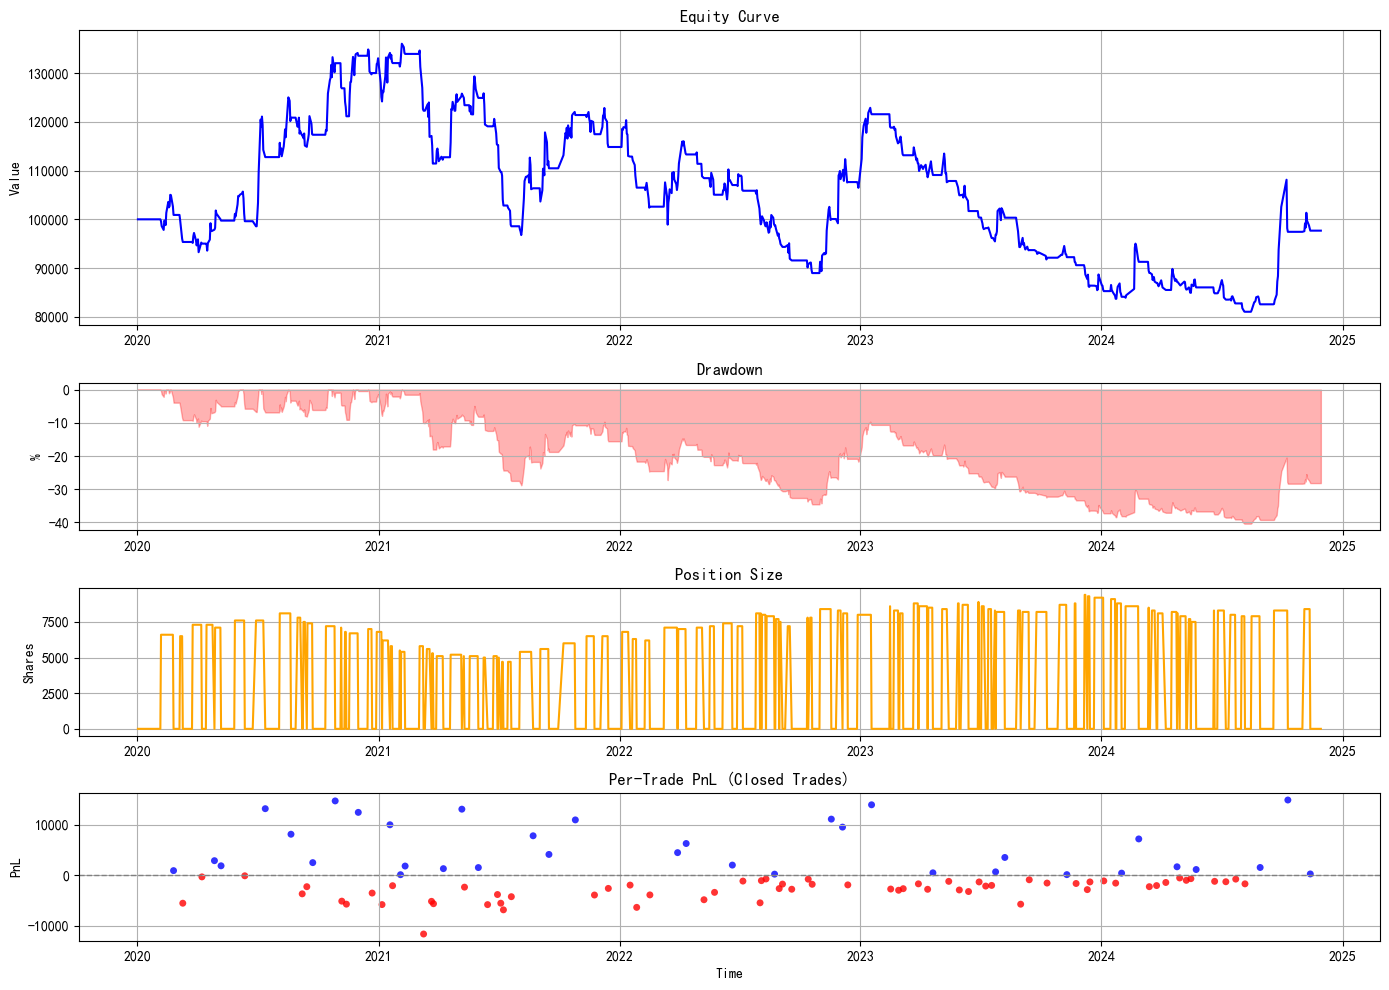

In [7]:
# ========================================
# 快速可视化回测结果（推荐方式）
# ========================================
# 使用 plot_from_results() 一行代码绘制四张图：
#   1. 资产曲线
#   2. 回撤曲线
#   3. 持仓变化
#   4. 每笔交易盈亏散点图（蓝=盈利, 红=亏损）
#
# 如需更多自定义，可使用:
#   from backtest.plotting import plot_backtest_results
#   plot_backtest_results(history, trades_df, data)
# ========================================

# 强制重新加载模块（开发时使用，确保获取最新代码）
import importlib
import backtest.plotting
importlib.reload(backtest.plotting)

from backtest.plotting import plot_from_results

plot_from_results(results, data)

### 5.3 查看交易记录

In [8]:
# ========================================
# 交易记录可视化（可选：调整显示数量）
# ========================================

# 可选：显示最近 N 笔交易（None 表示全部）
SHOW_LAST_N_TRADES = 20

if not trades_df.empty:
    print(f"\n📋 共完成 {len(trades_df)} 笔交易")
    print("\n最近交易记录:")
    
    display_df = trades_df.tail(SHOW_LAST_N_TRADES) if SHOW_LAST_N_TRADES else trades_df
    
    # 格式化输出
    for idx, row in display_df.iterrows():
        pnl = row.get('pnl', 0)
        pnl_str = f"¥{pnl:+,.2f}" if pnl != 0 else "N/A"
        print(f"  [{row.get('datetime', 'N/A')}] "
              f"买入价: {row.get('entry_price', 0):.2f} -> "
              f"卖出价: {row.get('exit_price', 0):.2f} | "
              f"数量: {row.get('quantity', 0)} | "
              f"盈亏: {pnl_str}")
else:
    print("⚠️ 无交易记录（可能策略未产生信号）")


📋 共完成 100 笔交易

最近交易记录:
  [2023-12-15 00:00:00] 买入价: 9.32 -> 卖出价: 9.19 | 数量: 9300 | 盈亏: ¥-1,306.26
  [2024-01-05 00:00:00] 买入价: 9.20 -> 卖出价: 9.09 | 数量: 9200 | 盈亏: ¥-1,105.00
  [2024-01-23 00:00:00] 买入价: 9.20 -> 卖出价: 9.04 | 数量: 9100 | 盈亏: ¥-1,546.94
  [2024-02-01 00:00:00] 买入价: 9.34 -> 卖出价: 9.40 | 数量: 8800 | 盈亏: ¥+431.55
  [2024-02-27 00:00:00] 买入价: 9.63 -> 卖出价: 10.48 | 数量: 8600 | 盈亏: ¥+7,191.89
  [2024-03-14 00:00:00] 买入价: 10.54 -> 卖出价: 10.29 | 数量: 8500 | 盈亏: ¥-2,245.76
  [2024-03-25 00:00:00] 买入价: 10.57 -> 卖出价: 10.34 | 数量: 8300 | 盈亏: ¥-2,028.12
  [2024-04-08 00:00:00] 买入价: 10.57 -> 卖出价: 10.41 | 数量: 8100 | 盈亏: ¥-1,413.55
  [2024-04-25 00:00:00] 买入价: 10.27 -> 卖出价: 10.49 | 数量: 8200 | 盈亏: ¥+1,685.95
  [2024-04-29 00:00:00] 买入价: 10.60 -> 卖出价: 10.55 | 数量: 8100 | 盈亏: ¥-525.40
  [2024-05-09 00:00:00] 买入价: 10.81 -> 卖出价: 10.70 | 数量: 7900 | 盈亏: ¥-990.81
  [2024-05-16 00:00:00] 买入价: 10.91 -> 卖出价: 10.84 | 数量: 7700 | 盈亏: ¥-660.97
  [2024-05-24 00:00:00] 买入价: 11.19 -> 卖出价: 11.36 | 数量: 7500 | 盈亏: ¥+1

## 6. 生成完整报告（可选）

使用 `BacktestReport` 生成包含图表和文字的完整回测报告。

In [ ]:
# ========================================
# 报告生成配置（可选）
# ========================================

# 可选：是否生成并保存报告
GENERATE_REPORT = True  # 改为 False 跳过报告生成

# 可选：报告保存目录
REPORT_OUTPUT_DIR = 'demo_reports'

if GENERATE_REPORT:
    print("正在生成回测报告...")
    
    # 强制重新加载模块（开发时使用）
    import importlib
    import backtest.report
    importlib.reload(backtest.report)
    from backtest.report import BacktestReport
    
    # 创建报告生成器
    reporter = BacktestReport(output_dir=REPORT_OUTPUT_DIR)
    
    # 生成报告
    report_path = reporter.generate_report(
        results=results,
        data=data,
        strategy_name='KDJ策略',
        symbol=SYMBOL,
        sizing_method=sizing_config.method,
        initial_capital=INITIAL_CAPITAL,
        save=True  # 可选：False 则仅返回路径不保存
    )
    
    print(f"\n✅ 报告已保存至: {report_path}")
    print("   报告包含:")
    print("   - summary.txt (文字报告)")
    print("   - equity_curve.png (资产曲线图)")
    print("   - drawdown.png (回撤图)")
    print("   - price_with_trades.png (买卖点标记图)")
    print("   - trade_pnl.png (每笔交易盈亏图)")
    print("   - metrics_summary.png (指标汇总图)")
else:
    print("⏭️ 跳过报告生成")

正在生成回测报告...
Report saved to: demo_reports\000001_SZ_KDJ策略_all_in_20251209_223451

✅ 报告已保存至: demo_reports\000001_SZ_KDJ策略_all_in_20251209_223451
   报告包含:
   - summary.txt (文字报告)
   - equity_curve.png (资产曲线图)
   - drawdown.png (回撤图)
   - price_with_trades.png (买卖点标记图)
   - metrics_summary.png (指标汇总图)


## 7. 策略优化建议

以下是一些可以尝试的优化方向：

### 参数调优
1. **调整 KDJ 周期**：尝试不同的 N 值（如 14, 21）观察效果
2. **启用超买超卖过滤**：取消代码中的注释，只在超买区卖出、超卖区买入
3. **启用 J 线辅助**：设置 `use_jline=True`，使用 J 线极值过滤信号

### 仓位管理
1. **分批建仓**：使用 `fixed_fraction` 或 `fixed_cash` 模式
2. **保留现金**：设置 `min_cash_fraction` 保留部分资金

### 信号增强
1. **结合其他指标**：如 MACD、RSI 进行信号确认
2. **增加止损止盈**：在策略中增加风险控制逻辑

---

**恭喜！您已完成 KDJ 策略的开发与回测演示。** 🎉